**Import neccessary libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=255
CHANNEL=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    directory='PlantVillage',
    seed=123,
    shuffle=True,
    image_size=[IMAGE_SIZE,IMAGE_SIZE],
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [7]:
len(dataset)

68

In [9]:
class_names=dataset.class_names

In [12]:
import numpy as np
for batch_size,label_size in dataset.take(1):
    print("image shape:",batch_size.shape)
    print("label:",label_size.numpy)
    print("image:",batch_size[0])

image shape: (32, 255, 255, 3)
label: <bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1,
       1, 2, 1, 0, 1, 1, 1, 0, 0, 0])>>
image: tf.Tensor(
[[[160.94319 145.94319 150.94319]
  [146.9765  131.9765  136.9765 ]
  [143.09195 128.09195 133.09195]
  ...
  [161.99217 141.99217 150.99217]
  [162.9961  142.9961  151.9961 ]
  [164.00002 144.00002 153.00002]]

 [[145.9961  130.9961  135.9961 ]
  [146.98831 131.98831 136.98831]
  [144.99222 129.99222 134.99222]
  ...
  [162.98431 142.98431 151.98431]
  [163.98824 143.98824 152.98824]
  [164.9863  144.9863  153.9863 ]]

 [[145.1803  130.1803  135.1803 ]
  [147.12769 132.12769 137.12769]
  [147.15744 132.15744 137.15744]
  ...
  [161.95108 141.95108 150.95108]
  [162.95491 142.95491 151.95491]
  [162.96078 142.96078 151.96078]]

 ...

 [[180.0137  166.0137  166.0137 ]
  [181.99994 167.99994 167.99994]
  [181.94147 167.94147 167.94147]
  

## Visualize some of the images from our dataset

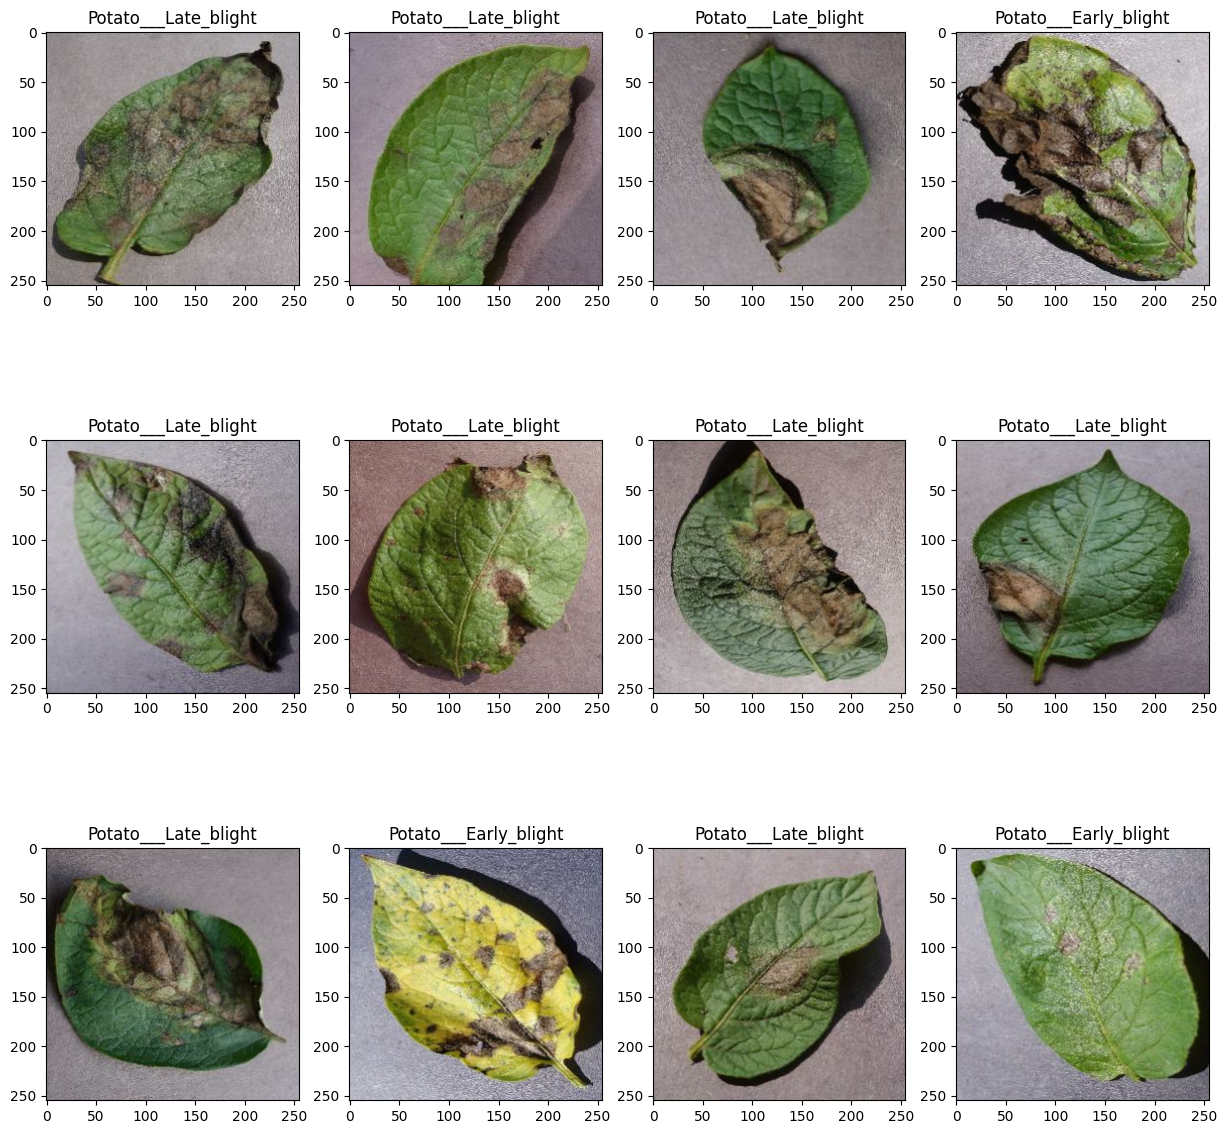

In [16]:
plt.figure(figsize=(15,15))
for img,label in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(class_names[label[i]])

## Function to split dataset

In [17]:
len(dataset)

68

In [18]:
train_size=0.8
len(dataset) * train_size

54.400000000000006

In [19]:
train_ds=dataset.take(54)

In [20]:
test_ds=dataset.skip(54)

In [21]:
len(test_ds)

14

In [22]:
val_size=0.1
len(dataset)* val_size

6.800000000000001

In [23]:
val_ds=test_ds.take(6)

In [24]:
len(val_ds)

6

In [26]:
test_ds=test_ds.skip(6)

In [27]:
len(test_ds)

8

In [28]:
(0.8 + 0.1 +0.1)==1

True

In [35]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split + val_split + test_split )==1
        
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


    

In [36]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [37]:
len(train_ds)

54

In [38]:
len(test_ds)

8

In [39]:
len(val_ds)

6

## Cache ,Shuffle, and Prefetch the Dataset

In [40]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


## Building the Model

In [42]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1./255)
])

## Data Augmentation

Data agumentation is needed when we have less data,this boosts the accuracy of our model by augmenting the data.

In [43]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Applying Data Augmentation to Train Dataset

In [44]:
train_ds=train_ds.map(lambda x,y: (data_augmentation(x,training=True),y)).prefetch(buffer_size=tf.data.AUTOTUNE)

In [45]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing , normalization and Data Augmentation.

In [54]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


## Compiling the model

We use adam Optimizer SparseCategoricalCrossentropy for losses , accuracy as a metric.

In [56]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [57]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=20)

Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4067 - loss: 0.9682 - val_accuracy: 0.5625 - val_loss: 0.8449
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.6105 - loss: 0.7689 - val_accuracy: 0.6406 - val_loss: 0.7422
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.7248 - loss: 0.6135 - val_accuracy: 0.7812 - val_loss: 0.4668
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.8216 - loss: 0.3926 - val_accuracy: 0.8125 - val_loss: 0.4380
Epoch 5/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.8401 - loss: 0.3613 - val_accuracy: 0.8750 - val_loss: 0.2881
Epoch 6/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8899 - loss: 0.2746 - val_accuracy: 0.8646 - val_loss: 0.2809
Epoch 7/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8950 - loss: 0.2529 - val_accuracy: 0.9323 - val_loss: 0.2173
Epoch 8/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.9264 - loss: 0.1885 - val_accuracy: 0.9219 - val_loss:

In [58]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.9917 - loss: 0.0242


In [59]:
scores

[0.02562469057738781, 0.9921875]

In [60]:
history

In [61]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [62]:
history.history['accuracy']

[0.46990740299224854,
 0.6545138955116272,
 0.7505787014961243,
 0.8373842835426331,
 0.8506944179534912,
 0.8917824029922485,
 0.9137731194496155,
 0.9247685074806213,
 0.9276620149612427,
 0.9525462985038757,
 0.9479166865348816,
 0.9554398059844971,
 0.9699074029922485,
 0.9641203880310059,
 0.9675925970077515,
 0.9809027910232544,
 0.9658564925193787,
 0.9785879850387573,
 0.9728009104728699,
 0.9728009104728699]

In [63]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

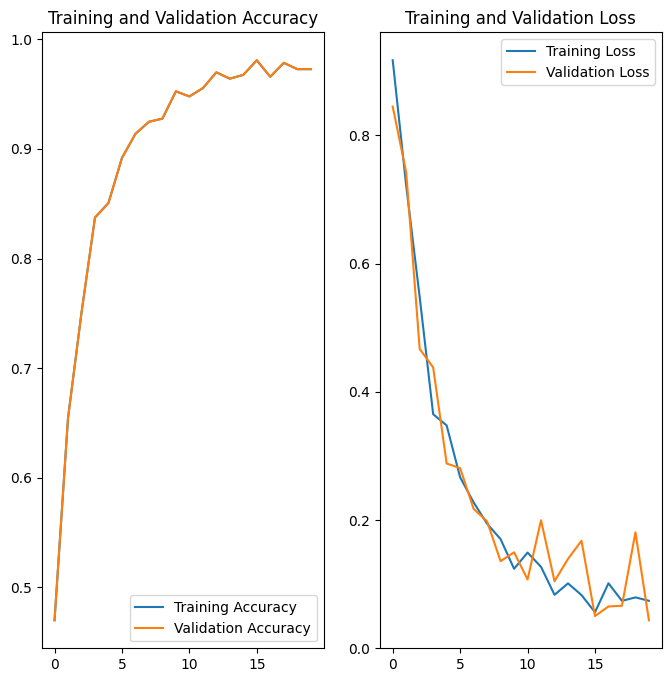

In [64]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Model

In [66]:
model.save('model.h5')

## Run prediction on a sample image

In [67]:
model=tf.keras.models.load_model('model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
Actual Label: Potato___Early_blight
Predicted Label: Potato___Early_blight


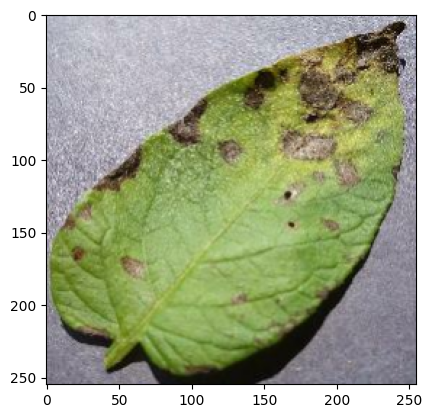

In [72]:
for img,label in test_ds.take(1):
    first_img=img[0].numpy().astype('uint8')
    first_label=label[0].numpy()

    pred_img=model.predict(img)

    plt.imshow(first_img)
    print("Actual Label:", class_names[first_label])
    print("Predicted Label:",class_names[np.argmax(pred_img[0])])

# Write a  function for prediction on more images

In [81]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(img)
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100 * (np.max(predictions[0])),2)
    
    return predicted_class,confidence,
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


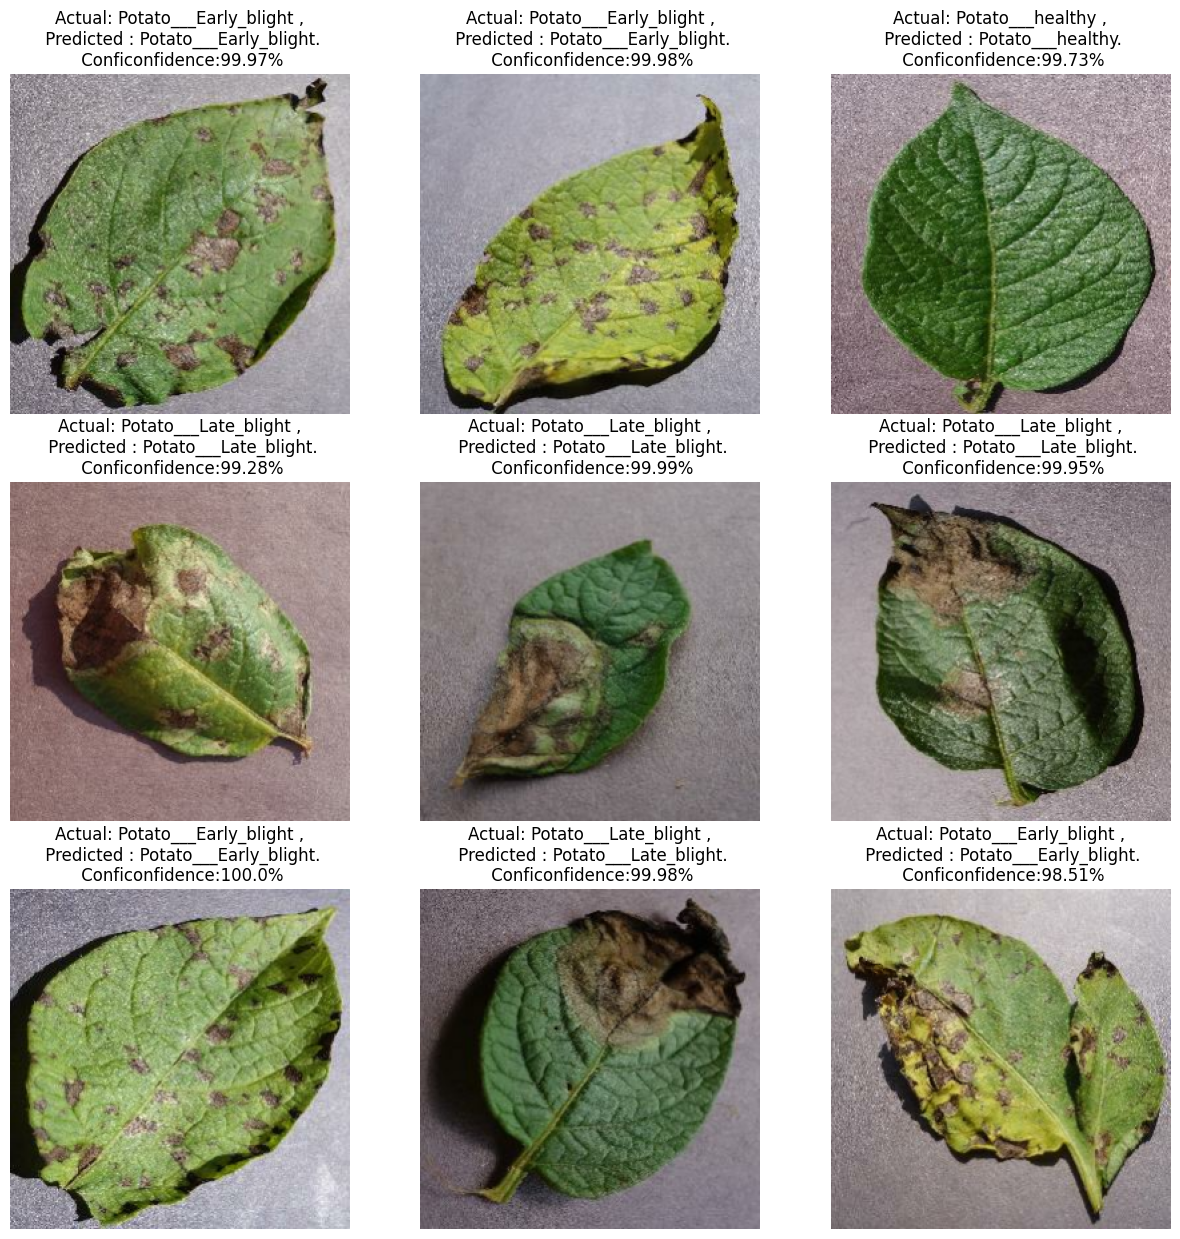

In [82]:
plt.figure(figsize=(15,15))

for img, label in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)

        predicted_class,confidence=predict(model,img[i].numpy())
        plt.imshow(img[i].numpy().astype("uint8"))
        actual_class=class_names[label[i]]
        plt.title(f"Actual: {actual_class} ,\n Predicted : {predicted_class}.\n Conficonfidence:{confidence}%")
        plt.axis("off")

In [83]:
print(tf.__version__)

2.18.0
